In [16]:
import time
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sentence_transformers.util import cos_sim
import sys
import key_words
from IPython.display import clear_output

import pickle
def save_obj(obj:object,name:str):
    ext = '.pickle'
    with open(name + ext, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(name:str)->object:
    ext = '.pickle'
    with open(name + ext, 'rb') as handle:
        return pickle.load(handle)

In [6]:
train_path = "data/train_phase1.tsv"
df = pd.read_csv(train_path, sep="\t")

In [3]:
def maximal_marginal_relevance(doc_embedding: np.ndarray,
        word_embeddings: np.ndarray,
        words,
        top_n = 5,
        diversity = 0.8):
    """
    Maximal Marginal Relevance algorithm for keyword extraction
    * from KeyBERT repository on github

    Args:
        doc_embedding (numpy.ndarray): embedding of shape (1, 768)
        word_embeddings (numpy.ndarray): embedding of shape (N, 768)
        words (List[str]): list of words
        top_n (Optional[int]): number of top words to extract
        diversity (Optional[float]): diversity of top words to extract

    Returns:
        List[Tuple[str, float]]: list of top_n words with their scores
    """
    # make sure 2d array
    if doc_embedding.ndim == 1:
        doc_embedding = doc_embedding.reshape(1, -1)

    # Extract similarity within words, and between words and the document

    word_doc_similarity = np.array(cos_sim(word_embeddings, doc_embedding)).clip(-1, 1).round(6)
    word_similarity = np.array(cos_sim(word_embeddings, word_embeddings)).clip(-1, 1).round(6)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate maximal_marginal_relevance
        mmr = (1-diversity) * candidate_similarities -\
            diversity * target_similarities.reshape(-1, 1)
        # if return mmr is empty
        if mmr.size == 0:
            continue
        mmr = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr)
        candidates_idx.remove(mmr)

    return [words[idx] for idx in keywords_idx]

def emb_keywords(keywords):
    # x = np.array(list(map(lambda k: np.array(list(map(lambda x: BERT.model.encode(str(x)), k))),keywords)))
    x = np.array(list(map(lambda k: np.array(list(map(lambda x: get_words_emb(str(x)), k))),keywords)))
    if x.ndim == 3:
        x = x.reshape(max(x.shape[1],x.shape[0]),x.shape[2])
    return x

def get_candidates(n_grams, doc):
    x = list(map(lambda gram :
        key_words.candidates_tokens(str(doc), n_gram_range=gram)
        , n_grams))
    return x

def match_keywords(
    keywords_emb:list[np.ndarray],
    candidates_emb : list[np.ndarray],
    thershold: float)\
        -> float:
    """
    match keywords with candidates in a document

    Args:
        keywords_emb (List[np.ndarray]): list of keywords embeddings
        candidates_emb (List[np.ndarray]): list of document's candidates embeddings
        thershold (float): threshold

    Returns:
        float: score
    
    example:
        >>> match_keywords(keywords_emb, candidates_emb, thershold=0.5)
        >>> 0.8
    """
    similarities = list(map(lambda cand:
                    cos_sim(np.array(keywords_emb), cand.reshape(cand.shape[0],cand.shape[1])).__array__().max(axis=1).round(6).clip(-1, 1),
                    candidates_emb))
    return similarities

def para_keywords_pipeline_output_dict(keywords,docs,n_gram_list,batch = 50):

    def check_n_gram_dict(n_grams, doc, ind):
        def fn(n_gram):
            x = n_gram_dict[ind].get(n_gram)
            if x is None:
                x =  get_candidates([n_gram], doc)
                n_gram_dict[ind][n_gram] = x
                return x
            else:
                return x
        return list(map(fn, n_grams))

    n_docs = len(docs)
    if n_docs < batch:
        batch = n_docs
    
    n_gram_dict = {ind: {n_gram: None for n_gram in set([item for sublist in n_gram_list for item in sublist])} for ind ,doc in enumerate(docs)}

    n_grams_list = []
    students_candidates_list = []
    keywords_embeddings_list = []
    students_candidates_emb_list = []
    times = []

    # all model answers
    for ind, ans in enumerate(keywords):
        print("model answer",ind)
        t1 = time.perf_counter()
        students_n_grams = key_words.get_n_grams(ans)
        keywords_embeddings =  list(map(model.encode, ans))

        students_candidates_list_s = []
        students_candidates_emb_list_s = []
        # do in batches
        for i in range(0,n_docs,batch):
            students_candidates = list(map(lambda doc:
                            check_n_gram_dict(students_n_grams, doc[1], i+doc[0]),
                            enumerate(docs[i:i+batch])))
            students_candidates_emb =  list(map( lambda st: list(map( emb_keywords ,st)), students_candidates))
            # students_candidates_emb =  list(map(emb_d, students_candidates))
            students_candidates_list_s.extend(students_candidates)
            students_candidates_emb_list_s.extend(students_candidates_emb)

        if n_docs % batch != 0 and n_docs > batch:
            students_candidates = list(map(lambda doc:
                            check_n_gram_dict(students_n_grams, doc[1], i+doc[0]),
                            enumerate(docs[i+batch:])))
            students_candidates_emb =  list(map( lambda st: list(map( emb_keywords ,st)), students_candidates))

            students_candidates_list_s.extend(students_candidates)
            students_candidates_emb_list_s.extend(students_candidates_emb)

        n_grams_list.append(students_n_grams)
        keywords_embeddings_list.append(keywords_embeddings)
        students_candidates_list.append(students_candidates_list_s)
        students_candidates_emb_list.append(students_candidates_emb_list_s)
        times.append(time.perf_counter() - t1)
    return {
        "n_gram_dict": n_gram_dict,
        "n_grams_list": n_grams_list,
        "students_candidates_list": students_candidates_list,
        "keywords_embeddings_list": keywords_embeddings_list,
        "students_candidates_emb_list": students_candidates_emb_list,
        "times": times
    }

def get_words_emb(word):
    if word in words_emb_dict:
        return words_emb_dict[word]
    else:
        words_emb_dict[word] = model.encode(word)
        return words_emb_dict[word]

def grading(keywords_embeddings_list,students_candidates_emb_list,thershold=0.5):
    """
    Args:
        keywords_embeddings_list: list of list of list of embeddings
        students_candidates_emb_list: list of list of list of embeddings
        thershold: thershold for the similarity
    Returns:
        a list of list of list of grades
    """
    grades = []
    for i in range(len(keywords_embeddings_list)):
        grades.append(np.array(list(map(lambda st_cand:
                match_keywords(keywords_embeddings_list[i], st_cand,
                thershold=thershold),
                students_candidates_emb_list[i]
                ))))
    grades = np.array(list(map(lambda sim: (sim.__array__().max(axis=1) >thershold).sum(axis=1)/float(sim.shape[-1]) , grades)))
    return grades

In [4]:
words_emb_dict = {}

In [4]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

In [4]:
ess_3_model_answers = load_obj('data/essaySet_3_model_answers')
docs = df.query(f'EssaySet == {3}')["EssayText"].values.tolist()

In [7]:
t1 = time.perf_counter()
docs_candidates = list(map(lambda ans: key_words.candidates_tokens(ans,n_gram_range=(2,3)),docs))
docs_candidate_emb = list(map(lambda cand:model.encode(cand),docs_candidates))

docs_emb = model.encode(docs)

docs_keywords = list(map(lambda x: maximal_marginal_relevance(
    x[0].reshape(1, -1),x[1],x[2],top_n=10 ,diversity=0.8),
    zip(docs_emb,docs_candidate_emb,docs_candidates)))

time.perf_counter() - t1

425.2485177

In [10]:
model_candidates = list(map(lambda ans: key_words.candidates_tokens(ans,n_gram_range=(2,3)),ess_3_model_answers))
model_candidate_emb = list(map(lambda cand:model.encode(cand),model_candidates))
keywords = list(map(lambda x: maximal_marginal_relevance(
    x[0].reshape(1, -1),x[1],x[2],top_n=10,diversity=0.8),
    zip(model.encode(ess_3_model_answers),
    model_candidate_emb,model_candidates)))

In [11]:
t1 = time.perf_counter()
docs_keywords_emb = list(map(lambda x: model.encode(x),docs_keywords))
print(time.perf_counter() - t1)

92.4907568000001


In [12]:
t1 = time.perf_counter()
keywords_emb = list(map(lambda x: model.encode(x),keywords))
print(time.perf_counter() - t1)

1.0961783000000196


In [42]:
s = list(map(lambda model_emb:
    list(map(lambda doc_emb: cos_sim(model_emb,doc_emb).__array__().max(axis=1), docs_keywords_emb)),keywords_emb))

In [57]:
for i in range(len(docs_keywords_emb)):
    if len(docs_keywords_emb[i]) !=10:
        print(i,docs_keywords_emb[i].shape)

5 (9, 384)
125 (1, 384)
226 (9, 384)
266 (9, 384)
551 (1, 384)
560 (7, 384)
609 (1, 384)
897 (7, 384)
906 (7, 384)
1137 (5, 384)
1453 (7, 384)
1457 (7, 384)
1633 (7, 384)
1703 (7, 384)
1887 (7, 384)


In [60]:
np.array(s)[0].shape

(1891, 10)

In [61]:
np.array(s).max(axis=0).shape

(1891, 10)

In [54]:
for i in range(len(s)):
    for j in range(len(s[i])):
        if s[i][j].shape[0] != 10:
            print(i,j,s[i][j].shape)

In [49]:
print(len(s))
print(len(s[0]))
print(s[0][-1].shape)

22
1891
(10,)


In [62]:
# save the data
os.makedirs('data/new_results', exist_ok=True)
save_obj(s,'data/new_results/essaySet_3_model_answers_grades')
save_obj(docs_keywords,'data/new_results/essaySet_3_model_answers_keywords')
save_obj(docs_keywords_emb,'data/new_results/essaySet_3_model_answers_keywords_emb')
save_obj(docs_candidates,'data/new_results/essaySet_3_model_answers_candidates')
save_obj(docs_candidate_emb,'data/new_results/essaySet_3_model_answers_candidates_emb')
save_obj(keywords,'data/new_results/essaySet_3_model_answers_keywords')
save_obj(keywords_emb,'data/new_results/essaySet_3_model_answers_keywords_emb')
save_obj(model_candidates,'data/new_results/essaySet_3_model_answers_candidates')
save_obj(model_candidate_emb,'data/new_results/essaySet_3_model_answers_candidates_emb')
save_obj(docs_emb,'data/new_results/essaySet_3_model_answers_docs_emb')

# output

In [6]:
# load the data from data new folder
s = load_obj('data/new_results/essaySet_3_model_answers_grades')
# docs_keywords = load_obj('data/new_results/essaySet_3_model_answers_keywords')
# docs_keywords_emb = load_obj('data/new_results/essaySet_3_model_answers_keywords_emb')
# docs_candidates = load_obj('data/new_results/essaySet_3_model_answers_candidates')
# docs_candidate_emb = load_obj('data/new_results/essaySet_3_model_answers_candidates_emb')
# keywords = load_obj('data/new_results/essaySet_3_model_answers_keywords')
# keywords_emb = load_obj('data/new_results/essaySet_3_model_answers_keywords_emb')
# model_candidates = load_obj('data/new_results/essaySet_3_model_answers_candidates')
# model_candidate_emb = load_obj('data/new_results/essaySet_3_model_answers_candidates_emb')
# docs_emb = load_obj('data/new_results/essaySet_3_model_answers_docs_emb')

In [8]:
np.array(s).shape

(22, 1891, 10)

In [160]:
keywords[0]

['pandas china similar',
 'specialists eats',
 'pythons different places',
 'live world',
 'food koalas',
 'bears australia specialists',
 'different places',
 'similar koala bears',
 'eats type food',
 'china similar koala']

In [ ]:
def para_keywords_pipeline_output_dict(keywords,docs,n_gram_list,batch = 50):

    def check_n_gram_dict(n_grams, doc, ind):
        def fn(n_gram):
            x = n_gram_dict[ind].get(n_gram)
            if x is None:
                x =  get_candidates([n_gram], doc)
                n_gram_dict[ind][n_gram] = x
                return x
            else:
                return x
        return list(map(fn, n_grams))

    n_docs = len(docs)
    if n_docs < batch:
        batch = n_docs
    
    n_gram_dict = {ind: {n_gram: None for n_gram in set([item for sublist in n_gram_list for item in sublist])} for ind ,doc in enumerate(docs)}

    n_grams_list = []
    students_candidates_list = []
    keywords_embeddings_list = []
    students_candidates_emb_list = []
    times = []

    # all model answers
    for ind, ans in enumerate(keywords):
        print("model answer",ind)
        t1 = time.perf_counter()
        students_n_grams = key_words.get_n_grams(ans)
        keywords_embeddings =  list(map(model.encode, ans))

        students_candidates_list_s = []
        students_candidates_emb_list_s = []
        # do in batches
        students_candidates = list(map(lambda ans: key_words.candidates_tokens(ans,n_gram_range=(3,3)),docs))

        for i in range(0,n_docs,batch):
            students_candidates_emb =  list(map( lambda st: list(map( emb_keywords ,st)), students_candidates))
            # students_candidates_emb =  list(map(emb_d, students_candidates))
            # students_candidates_list_s.extend(students_candidates)
            students_candidates_emb_list_s.extend(students_candidates_emb)

        if n_docs % batch != 0 and n_docs > batch:
            # students_candidates = list(map(lambda doc:
            #                 check_n_gram_dict(students_n_grams, doc[1], i+doc[0]),
            #                 enumerate(docs[i+batch:])))
            students_candidates_emb =  list(map( lambda st: list(map( emb_keywords ,st)), students_candidates))

            # students_candidates_list_s.extend(students_candidates)
            students_candidates_emb_list_s.extend(students_candidates_emb)

        n_grams_list.append(students_n_grams)
        keywords_embeddings_list.append(keywords_embeddings)
        students_candidates_list.append(students_candidates)
        # students_candidates_list.append(students_candidates_list_s)
        students_candidates_emb_list.append(students_candidates_emb_list_s)
        times.append(time.perf_counter() - t1)
    return {
        "n_gram_dict": n_gram_dict,
        "n_grams_list": n_grams_list,
        "students_candidates_list": students_candidates_list,
        "keywords_embeddings_list": keywords_embeddings_list,
        "students_candidates_emb_list": students_candidates_emb_list,
        "times": times
    }

In [11]:
top_n_l = [7]*10
diversity_l = [0.6,0.6, 0.7,0.7,0.7,0.7,0.6,0.7,0.7,0.7]
ngram_range_l = [(2,2),(2,2),(2,3),(2,3),(2,3),(2,3),(2,2),(2,3),(2,3),(2,3)]

In [18]:
dd = load_obj(f'data/results/new_keywords_res_essay_{1}')

## tune threshold

In [7]:
from IPython.display import clear_output

df_dict ={}

for i in range(1,11):
    df_dict['ess_'+str(i)+'_keywords'] = pd.DataFrame(df[df['EssaySet'] == i]['score_gn_1'])
    # remove index
    df_dict['ess_'+str(i)+'_keywords'].reset_index(drop=True, inplace=True)

In [8]:
def n_grading(keywords_emb, docs_keywords_emb, threshold = 0.5):
    # return np.array(list(map(lambda model_ans:
    #         np.array(list(map(lambda st: cos_sim(model_ans,st),docs_keywords_emb))),keywords_emb)))
    s = list(map(lambda model_emb: 
    list(map(lambda doc_emb: cos_sim(model_emb,doc_emb).__array__().max(axis=1), docs_keywords_emb)),keywords_emb))
    return np.array(s)

In [77]:
kwrds_model_1 = pd.DataFrame(np.array(s)[0])

In [78]:
kwrds_model_1 = pd.concat([kwrds_model_1,df_dict['ess_3_keywords']],axis=1)
kwrds_model_1.head()

,0,1,2,3,4,5,6,7,8,9,score_gn_1
0,0.837305,0.422338,0.573613,0.320906,0.908609,0.471892,0.210106,0.686953,0.560191,0.693069,0.490941
1,0.857505,0.665791,0.639898,0.354995,0.594003,0.721938,0.413970,0.757992,0.672203,0.724064,0.501053
2,0.826201,0.452897,0.695122,0.382576,0.695319,0.460464,0.404087,0.651537,0.663255,0.855351,0.512069
3,0.892339,0.518353,0.639417,0.261189,0.735989,0.355202,0.320354,0.583015,0.751305,0.772607,1.000000
4,0.970666,0.539734,0.745090,0.382576,0.772379,0.585845,0.404087,0.708652,0.186656,0.931490,0.000000


# train

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## score gn

In [79]:
# train the model
X = kwrds_model_1.drop(['score_gn_1'],axis=1)
# y = kwrds_model_1['Score1']
y = kwrds_model_1['score_gn_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models_dict = {
    'l_rg': LinearRegression(),
    'l_svr': SVR(),
    # 'l_knr': KNeighborsRegressor(),
    'l_dt': DecisionTreeRegressor(),
    'l_rf': RandomForestRegressor(),
    'l_gb': GradientBoostingRegressor(),
    'l_xgb': XGBRegressor(),
    'l_lgb': LGBMRegressor(),
    'l_cat': CatBoostRegressor(),
    'l_mlp': MLPRegressor(),
    # 'l_ada': AdaBoostRegressor(),
    'l_gpr': GaussianProcessRegressor(),
}
for model_name, mod in models_dict.items():
    mod.fit(X_train, y_train)
clear_output()

In [80]:
for mod_name, mod in models_dict.items():
    print(f"{mod_name} MSE:", mean_squared_error(y_test, mod.predict(X_test)))
    print(f"{mod_name} R2:", r2_score(y_test, mod.predict(X_test)))

l_rg MSE: 0.10710329118581877
l_rg R2: 0.021957777432861758
l_svr MSE: 0.11525404127518456
l_svr R2: -0.05247296736247775
l_dt MSE: 0.18152888799577185
l_dt R2: -0.6576793776346037
l_rf MSE: 0.11064180352932429
l_rf R2: -0.010355090255014021
l_gb MSE: 0.11253402993431857
l_gb R2: -0.02763445952789656
l_xgb MSE: 0.1363884140953992
l_xgb R2: -0.24546712035991747
l_lgb MSE: 0.1220731503505324
l_lgb R2: -0.11474347765342596
l_cat MSE: 0.11874790214478582
l_cat R2: -0.08437808822675286
l_mlp MSE: 0.10641849984983744
l_mlp R2: 0.02821113186130697
l_gpr MSE: 52.428854482718464
l_gpr R2: -477.7680452878236


In [81]:
for mod_name, mod in models_dict.items():
    print(f"{mod_name} MSE:", mean_squared_error(y_train, mod.predict(X_train)))
    print(f"{mod_name} R2:", r2_score(y_train, mod.predict(X_train)))

l_rg MSE: 0.10537809470371774
l_rg R2: 0.025248165515698417
l_svr MSE: 0.08722567743753308
l_svr R2: 0.19315879324423113
l_dt MSE: 0.0001310035177059902
l_dt R2: 0.9987882119185506
l_rf MSE: 0.01453660504597451
l_rf R2: 0.8655357882909464
l_gb MSE: 0.07335172935643414
l_gb R2: 0.3214933999916241
l_xgb MSE: 0.002293362951184971
l_xgb R2: 0.9787862956709255
l_lgb MSE: 0.02080765381026746
l_lgb R2: 0.8075283218974644
l_cat MSE: 0.021107626415543927
l_cat R2: 0.8047535626070219
l_mlp MSE: 0.10489501761596165
l_mlp R2: 0.029716649016102492
l_gpr MSE: 0.0001989206398683152
l_gpr R2: 0.9981599756650222


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

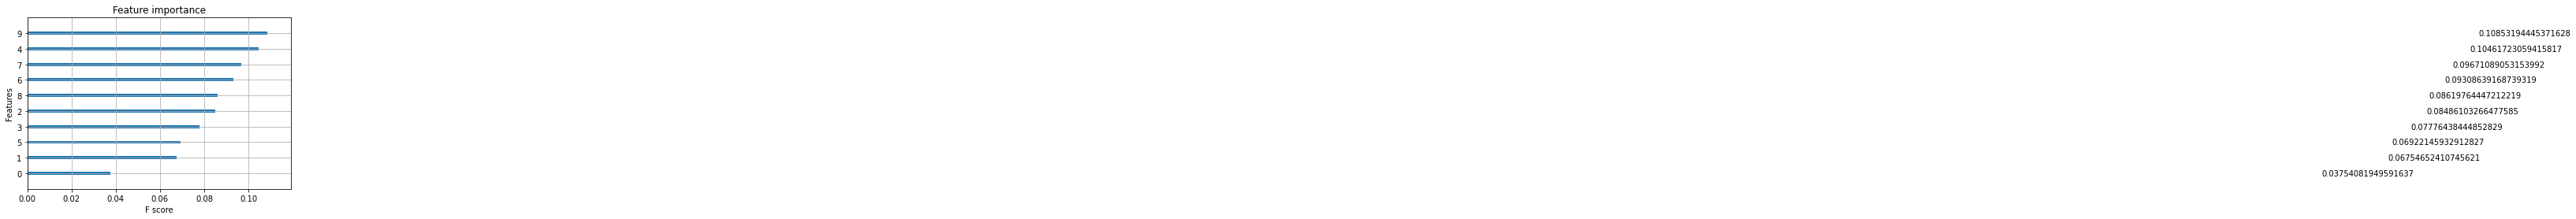

In [82]:
from xgboost import plot_importance
plot_importance(models_dict['l_xgb'],importance_type='gain')

In [107]:
eval_set = [(X_test, y_test)]
xgb = XGBRegressor( max_depth=2,n_estimators=5, learning_rate=0.25, subsample=0.2, colsample_bytree=0.8,)
# ,n_estimators=100,learning_rate=0.1)
xgb.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
# plot training deviance
# compute test set MSE
y_pred = xgb.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")

[0]	validation_0-error:0.48646
[1]	validation_0-error:0.48180
[2]	validation_0-error:0.45916
[3]	validation_0-error:0.48579
[4]	validation_0-error:0.49839
MSE: 0.11034230613825845
R2: -0.007620150079339139


## Score 1

In [ ]:
kwrds_model_1 = pd.DataFrame(np.array(s)[0])

In [ ]:
x = pd.DataFrame(df[df['EssaySet'] == 3]['Score1'])/4
x.reset_index(drop=True, inplace=True)
kwrds_model_1 = pd.concat([kwrds_model_1,x],axis=1)

In [ ]:
kwrds_model_1.head()

,0,1,2,3,4,5,6,7,8,9,Score1
0,0.837305,0.422338,0.573613,0.320906,0.908609,0.471892,0.210106,0.686953,0.560191,0.693069,0.25
1,0.857505,0.665791,0.639898,0.354995,0.594003,0.721938,0.413970,0.757992,0.672203,0.724064,0.25
2,0.826201,0.452897,0.695122,0.382576,0.695319,0.460464,0.404087,0.651537,0.663255,0.855351,0.25
3,0.892339,0.518353,0.639417,0.261189,0.735989,0.355202,0.320354,0.583015,0.751305,0.772607,0.50
4,0.970666,0.539734,0.745090,0.382576,0.772379,0.585845,0.404087,0.708652,0.186656,0.931490,0.00


In [71]:
# train the model
X = kwrds_model_1.drop(['Score1'],axis=1)
y = kwrds_model_1['Score1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
models_dict = {
    'l_rg': LinearRegression(),
    'l_svr': SVR(),
    'l_dt': DecisionTreeRegressor(),
    'l_rf': RandomForestRegressor(),
    'l_gb': GradientBoostingRegressor(),
    'l_xgb': XGBRegressor(),
    'l_lgb': LGBMRegressor(),
    'l_cat': CatBoostRegressor(),
    'l_mlp': MLPRegressor(),
    'l_gpr': GaussianProcessRegressor(),
}
for model_name, mod in models_dict.items():
    mod.fit(X_train, y_train)
clear_output()

In [74]:
for mod_name, mod in models_dict.items():
    print(f"{mod_name} MSE:", mean_squared_error(y_test, mod.predict(X_test)))
    print(f"{mod_name} R2:", r2_score(y_test, mod.predict(X_test)))

l_rg MSE: 0.02917206850394008
l_rg R2: 0.02440439056501109
l_svr MSE: 0.033348898260327955
l_svr R2: -0.11528048543680725
l_dt MSE: 0.052770448548812667
l_dt R2: -0.7647914787113295
l_rf MSE: 0.03057205528070947
l_rf R2: -0.022415085143363322
l_gb MSE: 0.03115390082480726
l_gb R2: -0.04187362844530451
l_xgb MSE: 0.03500002462505689
l_xgb R2: -0.1704987717861055
l_lgb MSE: 0.033972884512622856
l_lgb R2: -0.1361483319525414
l_cat MSE: 0.032574372105046524
l_cat R2: -0.08937816327603687
l_mlp MSE: 0.028978642055287943
l_mlp R2: 0.030873112316029183
l_gpr MSE: 19.0802420470046
l_gpr R2: -637.0966905209482


# sims

In [108]:
docs_emb.shape

(1891, 384)

In [137]:
docs_1_emb = model.encode(df[df['EssaySet'] == 1]["EssayText"].values.tolist())

In [138]:
# load essay set 1 model answers
essay_set_1_answers = load_obj(f'data/essaySet_1_model_answers')
set_1_answers_emb = model.encode(essay_set_1_answers)
doc1_sims = cos_sim(set_1_answers_emb, np.array(docs_1_emb)).__array__().max(axis=0)

In [146]:
doc1_df = pd.concat([pd.DataFrame(doc1_sims), pd.DataFrame(df[df['EssaySet'] == 1]['score_gn_1'])],axis=1)
doc1_df.shape

(1672, 2)

In [147]:
# train the model
X = doc1_df.drop(['score_gn_1'],axis=1)
y = doc1_df['score_gn_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models_dict = {
    'l_rg': LinearRegression(),
    'l_svr': SVR(),
    'l_dt': DecisionTreeRegressor(),
    'l_rf': RandomForestRegressor(),
    'l_gb': GradientBoostingRegressor(),
    'l_xgb': XGBRegressor(),
    'l_lgb': LGBMRegressor(),
    'l_cat': CatBoostRegressor(),
    'l_mlp': MLPRegressor(),
    'l_gpr': GaussianProcessRegressor(),
}
for model_name, mod in models_dict.items():
    mod.fit(X_train, y_train)
clear_output()

In [148]:
for mod_name, mod in models_dict.items():
    print(f"{mod_name} MSE:", mean_squared_error(y_test, mod.predict(X_test)))
    print(f"{mod_name} R2:", r2_score(y_test, mod.predict(X_test)))

l_rg MSE: 0.08269732247034495
l_rg R2: 0.2992851000775968
l_svr MSE: 0.08119784014044083
l_svr R2: 0.3119905853260575
l_dt MSE: 0.14593616000272852
l_dt R2: -0.2365532365094627
l_rf MSE: 0.10928567428355719
l_rf R2: 0.07399540842430719
l_gb MSE: 0.08120066102927147
l_gb R2: 0.31196668323617593
l_xgb MSE: 0.0989357285936552
l_xgb R2: 0.1616930622498306
l_lgb MSE: 0.08408942196929682
l_lgb R2: 0.2874894961577735
l_cat MSE: 0.08703721466508069
l_cat R2: 0.26251211838887545
l_mlp MSE: 0.08240117399827362
l_mlp R2: 0.30179443944640205
l_gpr MSE: 0.079830757887237
l_gpr R2: 0.32357421192512825


In [149]:
for mod_name, mod in models_dict.items():
    print(f"{mod_name} MSE:", mean_squared_error(y_train, mod.predict(X_train)))
    print(f"{mod_name} R2:", r2_score(y_train, mod.predict(X_train)))

l_rg MSE: 0.0797895457762088
l_rg R2: 0.31442788589102943
l_svr MSE: 0.07766760638632851
l_svr R2: 0.3326601299698658
l_dt MSE: 0.0001862585804170598
l_dt R2: 0.9983996188033755
l_rf MSE: 0.01644666047999878
l_rf R2: 0.8586861012227087
l_gb MSE: 0.06364711225071931
l_gb R2: 0.4531277891336568
l_xgb MSE: 0.025973412549452325
l_xgb R2: 0.7768298192585779
l_lgb MSE: 0.06629646140915622
l_lgb R2: 0.4303639058969134
l_cat MSE: 0.06398253726462903
l_cat R2: 0.4502457319208474
l_mlp MSE: 0.08015976909137576
l_mlp R2: 0.3112468328044091
l_gpr MSE: 0.07634098214760159
l_gpr R2: 0.34405882355966466


In [159]:
eval_set = [(X_test, y_test)]
xgb_1 = XGBRegressor( max_depth=2,n_estimators=5, learning_rate=0.4, subsample=0.2, colsample_bytree=0.8,)
# ,n_estimators=100,learning_rate=0.1)
xgb_1.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
y_pred = xgb_1.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")

[0]	validation_0-error:0.34055
[1]	validation_0-error:0.34055
[2]	validation_0-error:0.34055
[3]	validation_0-error:0.34500
[4]	validation_0-error:0.34796
MSE: 0.08158296617639564
R2: 0.3087273170160302


# keys

In [6]:
words_emb_dict = {}
def get_word_emb(word):
    if word in words_emb_dict:
        return words_emb_dict[word]
    else:
        words_emb_dict[word] = model.encode(word)
        return words_emb_dict[word]

def get_words_emb(words):
    return list(map(get_words_emb, words))
model_answers_dict = {
    1: load_obj(f'data/essaySet_{1}_model_answers'),
    2: load_obj(f'data/essaySet_{2}_model_answers'),
    3: load_obj(f'data/essaySet_{3}_model_answers'),
    4: load_obj(f'data/essaySet_{4}_model_answers'),
    5: load_obj(f'data/essaySet_{5}_model_answers'),
    6: load_obj(f'data/essaySet_{6}_model_answers'),
    7: load_obj(f'data/essaySet_{7}_model_answers'),
    8: load_obj(f'data/essaySet_{8}_model_answers'),
    9: load_obj(f'data/essaySet_{9}_model_answers'),
    10: load_obj(f'data/essaySet_{10}_model_answers'),
}

In [10]:
docs = df.query(f'EssaySet == {1}')["EssayText"].values.tolist()[:10]

In [11]:
def train():
    times = {}
    for essay in range(1,2):
        t = []
        clear_output()
        print(f"EssaySet: {essay} ...")
        t1 = time.perf_counter()
        model_answers = model_answers_dict[essay]
        # docs = df.query(f'EssaySet == {essay}')["EssayText"].values.tolist()[:10]
        t.append(time.perf_counter() - t1)

        print(f"docs cands ...")
        t1 = time.perf_counter()
        docs_candidates = list(map(lambda ans: key_words.candidates_tokens(ans,n_gram_range=(2,3)),docs))
        print(f"docs cands emb...")
        docs_candidate_emb = list(map(lambda cand: get_words_emb(cand),docs_candidates))
        t.append(time.perf_counter() - t1)

        print(f"Encoding ... docs")
        t1 = time.perf_counter()
        docs_emb = model.encode(docs)
        t.append(time.perf_counter() - t1)

        print(f"docs keywords ...")
        t1 = time.perf_counter()
        docs_keywords = list(map(lambda x: maximal_marginal_relevance(
            x[0].reshape(1, -1),x[1],x[2],top_n=10 ,diversity=0.8),
            zip(docs_emb,docs_candidate_emb,docs_candidates)))
        t.append(time.perf_counter() - t1)

        print(f"docs keywords emb ...")
        t1 = time.perf_counter()
        docs_keywords_emb = list(map(lambda x: get_words_emb(x),docs_keywords))
        t.append(time.perf_counter() - t1)

        print(f"model keywords ...")
        t1 = time.perf_counter()
        model_candidates = list(map(lambda ans: key_words.candidates_tokens(ans,n_gram_range=(2,3)),model_answers))
        model_candidate_emb = list(map(lambda cand: get_words_emb(cand),model_candidates))
        keywords = list(map(lambda x: maximal_marginal_relevance(
            x[0].reshape(1, -1),x[1],x[2],top_n=10,diversity=0.8),
            zip(model.encode(model_answers),
            model_candidate_emb,model_candidates)))
        t.append(time.perf_counter() - t1)

        print(f"model keywords emb ...")
        t1 = time.perf_counter()
        keywords_emb = list(map(lambda x: get_words_emb(x),keywords))
        t.append(time.perf_counter() - t1)

        s = list(map(lambda model_emb: 
            list(map(lambda doc_emb: cos_sim(model_emb,doc_emb).__array__().max(axis=1), docs_keywords_emb)),keywords_emb))
        
        # save the results
        np.save(f'data/results/essaySet_{essay}_keywords_scores',np.array(s))
        times[essay] = t
    return times

# all

In [27]:
# train_path = "data/train_phase1.tsv"
# df = pd.read_csv(train_path, sep="\t")
# keywords_threshold = 0.53
# kwrds_path = 'data/results/keys_score_0.53_essay'
# kwrds_res = load_obj(kwrds_path)
# siamese_scores = load_obj("data/results/final_siamese_scores")
ner_scores = load_obj("data/results/ner_res")
special_keywords_res = load_obj("data/results/special_keywords_res")

In [7]:
df.head()

,Unnamed: 0,Id,EssaySet,Score1,Score2,EssayText,score,score_gn,score_gn_1
0,0,1,1,1,1,Some additional information that we would need...,0.333333,0.343907,0.331842
1,1,2,1,1,1,"After reading the expirement, I realized that ...",0.333333,0.340896,0.365264
2,2,3,1,1,1,"What you need is more trials, a control set up...",0.333333,0.351329,0.354158
3,3,4,1,0,0,The student should list what rock is better an...,0.000000,0.000000,0.089832
4,4,5,1,2,2,For the students to be able to make a replicat...,0.666667,0.656207,0.710926


In [14]:
docs = df[df["EssaySet"]==2]["EssayText"].values.tolist()
docs1 = df[df["EssaySet"]==3]["EssayText"].values.tolist()
docs_emb = model.encode(docs)
docs1_emb = model.encode(docs1)

In [17]:
# model_answers
ess2 = model.encode(load_obj(f'data/essaySet_{2}_model_answers'))
ess3 = model.encode(load_obj(f'data/essaySet_{3}_model_answers'))

In [18]:
siamese_scores = []

siamese_scores.append(cos_sim(docs_emb,ess2).__array__().max(axis=1))
siamese_scores.append(cos_sim(docs1_emb,ess3).__array__().max(axis=1))

In [19]:
ner_scores = load_obj("data/results/ner_res")
special_keywords_res = load_obj("data/results/special_keywords_res")

In [34]:
score = df[df["EssaySet"]==2]["score_gn_1"].values.tolist()
score1 = df[df["EssaySet"]==3]["score_gn_1"].values.tolist()

In [37]:
n_df = pd.concat([pd.DataFrame(np.concatenate([siamese_scores[0],siamese_scores[1]])),
pd.DataFrame(np.concatenate([ner_scores[1],ner_scores[2]])),
pd.DataFrame(np.concatenate([special_keywords_res["ess_2_model_answers"],special_keywords_res["ess_3_model_answers"]])),
pd.DataFrame(np.array(score+score1))],axis=1)
n_df.columns = ['siamese_score', 'ner_score', 'special_keywords_score','label']

In [38]:
# train a regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train the model
X = n_df[['siamese_score', 'ner_score', 'special_keywords_score']]
y = n_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, model.predict(X_test)))
print("R2:", r2_score(y_test, model.predict(X_test)))

MSE: 0.10886717258549733
R2: 0.0351778337275136


In [40]:
# rg with regularization
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, model.predict(X_test)))
print("R2:", r2_score(y_test, model.predict(X_test)))

MSE: 0.10887742554349467
R2: 0.035086968125782936


In [42]:
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

In [49]:
# define model
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 100)
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.2612098601910762
Best Hyperparameters: {'alpha': 1.6159531754886576, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [50]:
model = Ridge(**{'alpha': 1.62, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'})
model.fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, model.predict(X_test)))
print("R2:", r2_score(y_test, model.predict(X_test)))

MSE: 0.11045588508102697
R2: 0.021098061146690106


In [52]:
# save the model
save_obj(model, 'data/results/model_rg.pkl')